In [1]:
import pandas as pd
import psycopg2 as pg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
engine = pg.connect("dbname='safeidx' user='fbk_mpba' host='172.104.247.67' port='5432' password='fbk2024$'")
df = pd.read_sql('select * from data_safeidx', con=engine)

/tmp/ipykernel_46791/2472232159.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/tmp/ipykernel_46791/2472232159.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('select * from data_safeidx', con=engine)


In [2]:
df.head()

difficulty             cause     town province gender equipment helmet  \
0     novice        fall_alone   SIKLOS               F       ski   None   
1   advanced        fall_alone    MALMO               M       ski   None   
2   advanced        fall_alone  CALDARO       BZ      F       ski   None   
3   advanced  collision_person     LINZ               M       ski   None   
4   advanced  collision_person   RUSAVA               M       ski   None   

               destination   diagnosis india   age          country  \
0  hospital_emergency_room  distortion  None  32.0         Ungheria   
1  hospital_emergency_room      bruise  None  32.0           Svezia   
2                 domicile       other  None  12.0           Italia   
3  hospital_emergency_room      bruise  None  58.0          Austria   
4                    other      bruise  None  25.0  Repubblica Ceca   

  injury_side injury_general_location evacuation_vehicles  
0           L             lower_limbs              [akja]  
1           R           skull_or_face              [akja]  
2           R                    None        [snowmobile]  
3           R             lower_limbs        [snowmobile]  
4           L             lower_limbs             [other]

In [3]:
ev = set({})
for i,row in df.iterrows():
    ev = ev.union(set(row.evacuation_vehicles))

In [4]:
for c in ev:
    df[c] = False
for i,row in df.iterrows():
    for c in row.evacuation_vehicles:
        df.loc[i,c] = True

In [5]:
df.drop(columns=['town','province','evacuation_vehicles'],inplace=True)

(array([1.3808e+04, 0.0000e+00, 8.8100e+02, 0.0000e+00, 0.0000e+00,
        3.3690e+03, 0.0000e+00, 1.5200e+02, 0.0000e+00, 1.1000e+01]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

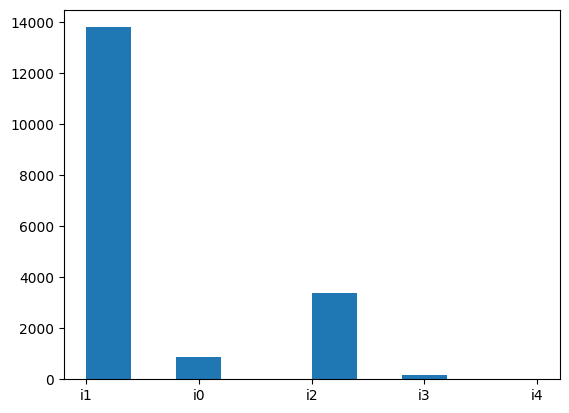

In [36]:
labeled = df[~pd.isna(df.india)]
plt.hist(labeled.india)

In [37]:
labeled['age'] =  labeled['age'].astype(np.float32).fillna(np.nan)
for c in labeled.columns:
    if c!='age':
        labeled[c] =  labeled[c].fillna('None').astype('category')
labeled.dropna(inplace=True)

/tmp/ipykernel_46791/382759161.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled['age'] =  labeled['age'].astype(np.float32).fillna(np.nan)
/tmp/ipykernel_46791/382759161.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled[c] =  labeled[c].fillna('None').astype('category')
/tmp/ipykernel_46791/382759161.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [38]:
X_train, X_test, y_train, y_test = train_test_split( labeled.drop(columns=['india']),
                                                    labeled.india, test_size=0.33, random_state=0,stratify=labeled.india)

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.33, random_state=0,stratify=y_train)

In [40]:
w = pd.DataFrame(np.unique(y_train,return_counts=True)).T
w.columns = ['class','p']
w.p = np.sqrt(w.p.sum())/w.p
weight_train = pd.merge(pd.DataFrame({'class':y_train}),w).p.values

In [26]:
#weight_train = (1-y_train.values.astype(int))*5+1 ## peso classi unbalanced

In [42]:
from catboost import CatBoostClassifier, Pool

train_data = Pool(data=X_train,
                  label=y_train,
                 cat_features=[c for c in X_train.columns if c!='age'])
valid_data = Pool(data=X_valid,
                  label=y_valid,cat_features=[c for c in X_train.columns if c!='age']
                  )
model = CatBoostClassifier(iterations=1000)

model.fit(train_data,eval_set=valid_data,verbose=False,early_stopping_rounds=100)
preds_class = model.predict(valid_data,)

In [43]:
preds_class_valid = model.predict(valid_data)
preds_class_train= model.predict(train_data)

In [44]:
from sklearn.metrics import confusion_matrix,matthews_corrcoef,accuracy_score

In [45]:
print(confusion_matrix(y_valid,preds_class_valid))
print(matthews_corrcoef(y_valid,preds_class_valid))
print(accuracy_score(y_valid,preds_class_valid))
print('########################################')
print(confusion_matrix(y_train,preds_class_train))
print(matthews_corrcoef(y_train,preds_class_train))
print(accuracy_score(y_train,preds_class_train))

[[ 145   40    2    0    0]
 [  98 2388  555    2    0]
 [   1  211  512   20    0]
 [   0    3   21   10    0]
 [   0    1    0    0    1]]
0.4797388666004143
0.7620947630922693
########################################
[[ 349   27    3    0    0]
 [ 194 5033  946    4    0]
 [   6  274 1213   17    0]
 [   0    3   12   53    0]
 [   1    0    0    0    4]]
0.6100405041372103
0.8172994225334808


In [134]:
##try with xgboost
import xgboost as xgb

# Create regression matrices
dtrain = xgb.DMatrix(X_train,y_train.apply(lambda x:x.replace('i','')).astype(int), enable_categorical=True,feature_names=list(X_train.columns.values))#,weight=weight_train)
dvalid = xgb.DMatrix(X_valid,y_valid.apply(lambda x:x.replace('i','')).astype(int), enable_categorical=True,feature_names=list(X_train.columns.values))

params = {"objective": "multi:softprob", "num_class": 5}
n = 1000

results = xgb.train(
   params, dtrain,

   num_boost_round=n,
  evals = [(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=False,
    early_stopping_rounds=100
  # metrics=["mlogloss", "auc", "merror"],
)
preds_class_valid = results.predict(dvalid)
preds_class_train= results.predict(dtrain)
print(confusion_matrix(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid.argmax(1)))
print(matthews_corrcoef(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid.argmax(1)))
print(accuracy_score(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid.argmax(1)))
print('########################################')
print(confusion_matrix(y_train.apply(lambda x:x.replace('i','')).astype(int),preds_class_train.argmax(1)))
print(matthews_corrcoef(y_train.apply(lambda x:x.replace('i','')).astype(int),preds_class_train.argmax(1)))
print(accuracy_score(y_train.apply(lambda x:x.replace('i','')).astype(int),preds_class_train.argmax(1)))

[[ 123   63    1    0    0]
 [  26 2826  191    0    0]
 [   1  440  297    6    0]
 [   0    4   25    5    0]
 [   0    2    0    0    0]]
0.4591984245284171
0.8107231920199501
########################################
[[ 376    3    0    0    0]
 [   0 6123   54    0    0]
 [   0  261 1249    0    0]
 [   0    0    0   68    0]
 [   0    0    0    0    5]]
0.8974734086657309
0.9609288610394398


In [115]:
import shap

pred = results.predict(dvalid, output_margin=True,)

explainer = shap.TreeExplainer(results,feature_names=list(X_train.columns.values))
explanation = explainer(dvalid)

shap_values = explanation.values
shap_values.shape

(4010, 24, 5)

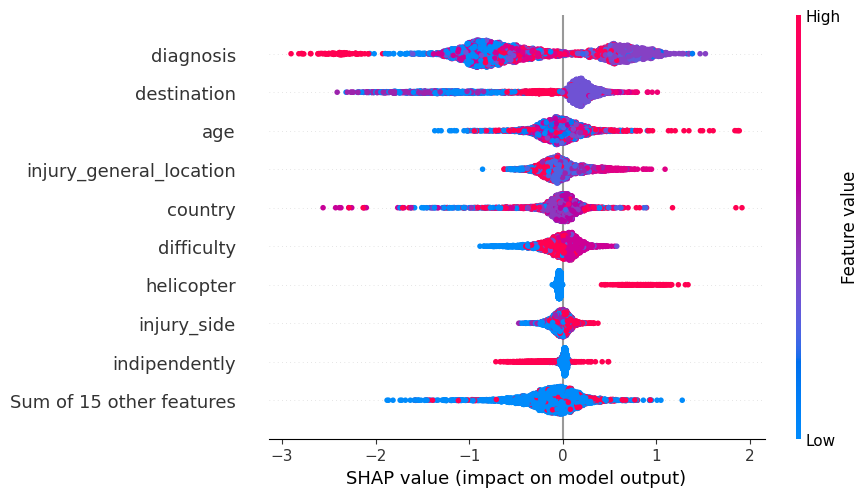

In [119]:
shap.plots.beeswarm(explanation[:,:,2])


In [132]:
vals= np.abs(shap_values).mean(0).mean(1)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.col_name[0:10].values

array(['diagnosis', 'destination', 'age', 'helicopter',
       'injury_general_location', 'difficulty', 'cause', 'country',
       'injury_side', 'ski_lift'], dtype=object)

In [135]:
##try with xgboost
import xgboost as xgb
X_train_small = X_train[feature_importance.col_name[0:10].values]
X_valid_small = X_valid[feature_importance.col_name[0:10].values]

# Create regression matrices
dtrain = xgb.DMatrix(X_train_small,y_train.apply(lambda x:x.replace('i','')).astype(int), enable_categorical=True,feature_names=list(X_train_small.columns.values))#,weight=weight_train)
dvalid = xgb.DMatrix(X_valid_small,y_valid.apply(lambda x:x.replace('i','')).astype(int), enable_categorical=True,feature_names=list(X_train_small.columns.values))

params = {"objective": "multi:softprob", "num_class": 5}
n = 1000

results = xgb.train(
   params, dtrain,

   num_boost_round=n,
  evals = [(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=False,
    early_stopping_rounds=100
  # metrics=["mlogloss", "auc", "merror"],
)
preds_class_valid = results.predict(dvalid)
preds_class_train= results.predict(dtrain)
print(confusion_matrix(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid.argmax(1)))
print(matthews_corrcoef(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid.argmax(1)))
print(accuracy_score(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid.argmax(1)))
print('########################################')
print(confusion_matrix(y_train.apply(lambda x:x.replace('i','')).astype(int),preds_class_train.argmax(1)))
print(matthews_corrcoef(y_train.apply(lambda x:x.replace('i','')).astype(int),preds_class_train.argmax(1)))
print(accuracy_score(y_train.apply(lambda x:x.replace('i','')).astype(int),preds_class_train.argmax(1)))

[[ 118   67    2    0    0]
 [  30 2794  217    2    0]
 [   0  435  300    9    0]
 [   0    5   24    5    0]
 [   0    2    0    0    0]]
0.43952307639594157
0.8022443890274314
########################################
[[ 371    8    0    0    0]
 [   1 6091   85    0    0]
 [   0  353 1156    1    0]
 [   0    0    0   68    0]
 [   0    0    0    0    5]]
0.8543147994467417
0.9449563828480158


In [54]:
model = xgb.XGBClassifier(n_estimators=1000,objective="multi:softprob",num_class=5,enable_categorical=True)
model.fit(X_train, y_train.apply(lambda x:x.replace('i','')).astype(int), early_stopping_rounds=100,eval_set = [(X_valid, y_valid.apply(lambda x:x.replace('i','')).astype(int))],verbose=False)

/home/agobbi/miniconda3/envs/pid/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, num_class=5,
              num_parallel_tree=None, ...)

In [55]:
preds_class_valid = model.predict(X_valid)
preds_class_train= model.predict(X_train)

In [60]:
preds_class_valid.max()

4

In [61]:
print(confusion_matrix(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid))
print(matthews_corrcoef(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid))
print(accuracy_score(y_valid.apply(lambda x:x.replace('i','')).astype(int),preds_class_valid))
print('########################################')
print(confusion_matrix(y_train.apply(lambda x:x.replace('i','')).astype(int),preds_class_train))
print(matthews_corrcoef(y_train.apply(lambda x:x.replace('i','')).astype(int),preds_class_train))
print(accuracy_score(y_train.apply(lambda x:x.replace('i','')).astype(int),preds_class_train))

[[ 125   61    1    0    0]
 [  15 2885  143    0    0]
 [   1  440  296    7    0]
 [   1    5   24    4    0]
 [   0    1    0    0    1]]
0.49681030860342146
0.8256857855361596
########################################
[[ 294   84    1    0    0]
 [  18 5995  164    0    0]
 [   1  739  770    0    0]
 [   0    9   18   41    0]
 [   1    0    1    0    3]]
0.6440004170345552
0.8727116353360364
